<a href="https://colab.research.google.com/github/fabiodr/colabs/blob/main/Introduction_to_token_sampling_2_Attention_paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 align="center"></h3>
<h1 align="center">The Quest for Best Tokens - An Introduction to LLM Sampling</h1>

---

<h1 align="center">2. Attention paths and dynamics</h1>

<img src="https://raw.githubusercontent.com/Pleias/Quest-Best-Tokens/refs/heads/main/generatio_2.png">

This notebook belong to our series of pedagogic experiments around LLM sampling, partly in connection to the Entropix project. It focuses more specifically on one part of token selection: attention weight, basically what the models *attends to* while selecting the tokens and how we can use this information to provide better token selection strategy.

We're going to use a new model pretrained for RAG application, Pleias-Pico. Despite its small size (350 million parameters), Pleias-Pico is multilingual and has a built-in support for citation: basically it will ground text generations with references and extent quote to submitted sources. This behavior makes it an ideal experimental setup to study attention weight, as citation will naturally select for long range attention paths.

There is not prerequesite to follow on this notebook except a general familiarity with LLMs and transformers, despite its overall experimental nature.

## Setting up the models.

First let's start with importing Pleias-Pico:

In [ ]:
# First, let's import our required libraries
import torch
from torch.nn import functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

# Let's use GPT-2 small for this example
model_name = "PleIAs/Pleias-Pico"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.41k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

As in the first course, we'll give a brief look to the overall structure of the model.

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(65536, 1024)
    (layers): ModuleList(
      (0-25): 26 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=512, bias=False)
          (v_proj): Linear(in_features=1024, out_features=512, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=2560, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2560, bias=False)
          (down_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1024,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1024,), eps=1e-05)
      )
    )
    (norm): 

Similarly to Smollm, we are dealing with a Llama-type model, which is also ultimately a gpt-neox-type model, since Llama 1 took a significant inspiration from the Eleuther model design.


Pleias is an entirely new model, pretrained on Pleias fully open dataset, Common Corpus, and with its own tokenizer. We volontarily opted for a slightly larger tokenizer than is customary with very small model, to expand on the language support: with 65536 tokens, Pleias-Pico is able to generate correct texts in English, French, Italian or German, with not a big inference cost in thoses languages.

## Is Wikipedia reliable?

We'll start experimenting with the model particular design with a relatively long prompt. Pleias-Pico is made to work within a RAG application and to be plugged to an existing dataset of resources. To keep things simpler, we'll just load a prepared prompt made of the following elements:
* A query (so Is Wikipedia accurate?)
* A list of references with special tokens for the source id (a hash) and for the texts.
* A special tokens signalling the start of the model generation.

In [ ]:
# Our input prompt
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>"""
print(f"Prompt: {prompt}")

Prompt: <|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2

We'll start by converting this text into tokens:

In [ ]:
input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)
print(f"\nTokenized input shape: {input_ids.shape}")
print(f"Last Token IDs: {input_ids[0].tolist()[-10:]}")
print(f"Last Decoded tokens: {[tokenizer.decode([id]) for id in input_ids[0].tolist()[-10:]]}")


Tokenized input shape: torch.Size([1, 455])
Last Token IDs: [14791, 6431, 296, 39640, 408, 10642, 17, 65517, 189, 65514]
Last Decoded tokens: [' edit', ' articles', ' to', ' disclose', ' that', ' arrangement', '.', '<|source_end|>', '\n', '<|source_analysis_start|>']


As we can notice the special tokens are converted into whole tokens, using the last ids from the tokenizer. English is generally one token per words with Pleias-Pico, except here for "encyclopedia" (although notice the cyclopedia is not a very useful tokens and this is an issue our alternative tokenization methods "picky BPE" aims to adress). Yet, tokenization in other European languages should fare relatively were too:

In [ ]:
french_prompt = "Nous sommes une encyclopédie. <|source_end|>\n<|source_analysis_start|>"
french_input_ids = tokenizer.encode(french_prompt, return_tensors='pt')
french_input_ids = french_input_ids.to(device)
print(f"\nTokenized input shape: {french_input_ids.shape}")
print(f"Token IDs: {french_input_ids[0].tolist()}")
print(f"Decoded tokens: {[tokenizer.decode([id]) for id in french_input_ids[0].tolist()]}")


Tokenized input shape: torch.Size([1, 12])
Token IDs: [1, 30362, 12093, 1048, 374, 27242, 30373, 17, 211, 65517, 189, 65514]
Decoded tokens: ['<|begin_of_text|>', 'Nous', ' sommes', ' une', ' en', 'cyclop', 'édie', '.', ' ', '<|source_end|>', '\n', '<|source_analysis_start|>']


We're not there in the most interesting part of text generation for attention paths: Pleias-Pico proceeds in two steps, with first a source analysis and then the proper RAG synthesis. So we'll start doing a full generation first using simply model generate:

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt", padding=False).to(device)

outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=1000,
            repetition_penalty=1,
            do_sample=False,
            early_stopping=True,
            use_cache=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=2
        )

result = tokenizer.decode(outputs[0], skip_special_tokens=False)

print(result)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC Wo

As you can notice we set up a deterministic generation with no temperature. If you remember the previous notebook, we are simply taking the most probably tokens predicted by the model without any random sampling or temperature adjustment.

Now we are going to retroactively integrate the source analysis part as well as the beginning of the sourced summary:

In [ ]:
# Our input prompt
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|>Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|>As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|>Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\""""
print(f"Prompt: {prompt}")

Prompt: <|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|>Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|>As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 rega

Notice that we have slightly modified the text, adding a reference just after the first statement. The missing expected part now is a reference id, basically any of the references the model should opt for.

For text generation we are going back to a token per token approach. So let's check what is the next token logits:

In [ ]:
input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
  outputs = model(input_ids)

token_logits = outputs.logits[0]
reference_token_logits = token_logits[-1]

print(reference_token_logits)

tensor([ 0.5404,  2.9403, 12.2488,  ..., 14.9256, 13.0676,  9.0764],
       device='cuda:0')


We are going to list all the token suggestions, knowing that the model currently only select the most probable token:

In [ ]:
import pandas as pd
token_data = []
#We iterate over all the tokens per id
for token_id in range(len(reference_token_logits)):
    token = tokenizer.decode([token_id])
    logit = reference_token_logits[token_id].item()
    token_data.append((token_id, token, logit))

df = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit'])

df.sort_values(by='Logit', ascending=False)

,Token ID,Token,Logit
72,72,e,31.000648
252,252,en,24.998991
24,24,5,24.268187
2428,2428,www,24.199272
2102,2102,En,23.592836
...,...,...,...
63246,63246,iß,-2.454522
10405,10405,indows,-2.659615
42223,42223,ôtés,-3.120685
29104,29104,initon,-4.045396


Basically our model is ranking the **most probable** sources it can use, based on the past information. This generally fits with our expectation while reading the text: the first source is the one most likely to fit with the statement. Other token suggestions would be source id hallucinations and should be disprove. This shows that in the current design of the model it's difficult to use a continuous temperature sampling as some of the steps, like source selection, really need to be constrained to the main token.

Let's go now with the first source. We recreate the prompt, only filling it with the full source id and the general design for quotations.

In [ ]:
# Our input prompt
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|>Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|>As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|>Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\""""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
  outputs = model(input_ids)

token_logits = outputs.logits[0]
reference_token_logits = token_logits[-1]

token_data = []
#We iterate over all the tokens per id
for token_id in range(len(reference_token_logits)):
    token = tokenizer.decode([token_id])
    logit = reference_token_logits[token_id].item()
    token_data.append((token_id, token, logit))

df = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit'])

df.sort_values(by='Logit', ascending=False)

,Token ID,Token,Logit
68,68,a,28.588072
1139,1139,the,27.955166
53542,53542,Wik,27.250229
885,885,The,26.723719
36,36,A,26.170721
...,...,...,...
18113,18113,kezd,-2.997007
33856,33856,ersche,-3.043692
19801,19801,λό,-3.308999
61070,61070,kockázat,-3.401935


What we do see now is **different paths** for quotation. The model is going back to the original source and consider the following options for citation start:
* "a" which is likely "a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica"
* "the" which is likely "the average science entry in Wikipedia".
* finally Wikipedia, which is probably "Wikipedia contained around four inaccuracies"

Let's try now by autocompleting the main citation path.

In [ ]:
# Our input prompt
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\"a"""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
  outputs = model(input_ids)

token_logits = outputs.logits[0]
reference_token_logits = token_logits[-1]

token_data = []
#We iterate over all the tokens per id
for token_id in range(len(reference_token_logits)):
    token = tokenizer.decode([token_id])
    logit = reference_token_logits[token_id].item()
    token_data.append((token_id, token, logit))

df = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit'])

print("Citation path 1: a")

df.sort_values(by='Logit', ascending=False)

Citation path 1: a


,Token ID,Token,Logit
18993,18993,peer,17.463982
3863,3863,review,11.892138
2908,2908,top,11.395664
1976,1976,study,11.131575
45108,45108,Peer,11.021330
...,...,...,...
39457,39457,niczą,-17.974104
33856,33856,ersche,-18.103682
56976,56976,vnú,-19.387606
29814,29814,lakan,-19.449608


It's definitely "a peer review". And you can notice that the logit is now much more concentrated on the first token suggestion since the model is now getting highly confident since it was trained to provide literal sources. As attention is firmly anchored on the text to quote, the second suggestion is simply the next word. Like a good chess player, our tiny models is already anticipating its next moves.

We can now see citation path two:

In [ ]:
# Our input prompt
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\""""

#ebea70a3502acfbd\">\"

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
  outputs = model(input_ids)

token_logits = outputs.logits[0]
reference_token_logits = token_logits[-1]

token_data = []
#We iterate over all the tokens per id
for token_id in range(len(reference_token_logits)):
    token = tokenizer.decode([token_id])
    logit = reference_token_logits[token_id].item()
    token_data.append((token_id, token, logit))

df = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit'])

print("Citation path 2: the")

df.sort_values(by='Logit', ascending=False)

Citation path 2: the


,Token ID,Token,Logit
68,68,a,28.647232
1139,1139,the,27.935005
53542,53542,Wik,27.490597
885,885,The,26.695280
41066,41066,Articles,26.335514
...,...,...,...
58064,58064,£),-3.048710
33856,33856,ersche,-3.072455
19801,19801,λό,-3.247936
61070,61070,kockázat,-3.366449


Again predictably, only the first token is enough ton create a new regular path of generation. In entropix jargon, we would say that the first token of the citation id and the first id of the quote are "exploring forks in the path", while, once the decision have been made, the next tokens have a much lower entropy and "flowing with unspoken intent".

While they are many ways to explore this mechanism, I feel the best way to visualize it is from another set of model weights we haven't used until now: attention weights.

## Exploring forks with attention weights

To use attention weights, we need to change the standard model outputs, using a "hook". Basically we tell pytorch to keep the attentions weights until the end so that we can leverage this information.

We'll start first with the input stopped before the reference id:

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\""""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

Just for safety, we clear the preexisting hooks:

In [ ]:
for name, module in model.named_modules():
    module._forward_hooks.clear()
    module._backward_hooks.clear()

And now we can predict the next tokens with attention outputs enabled

In [ ]:
with torch.no_grad():
  outputs = model(
      input_ids,
      output_attentions=True,
      return_dict=True
)

  attention_weights = outputs.attentions

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Attention weights are available for all layers, so that we can immediately check the preferred tokens per layers:

In [ ]:
import numpy as np

for layer_idx, layer_attention in enumerate(attention_weights):

  # Convert to numpy and get last token attention
  layer_attention_np = layer_attention.cpu().numpy()

  # Average across heads for the last token's attention
  # Shape should be [batch, heads, seq_len, seq_len]
  last_token_attention = layer_attention_np[0, :, -1, :]  # Get all heads, last token
  mean_attention = np.mean(last_token_attention, axis=0)  # Average across heads

  # Get tokens for interpretation
  tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

  print("Most attended tokens:")
  top_indices = np.argsort(mean_attention)[-1:][::-1]
  for idx in top_indices:
    print(f"{tokens[idx]}: {mean_attention[idx]:.4f}")

Most attended tokens:
=": 0.0784
Most attended tokens:
Ġname: 0.1568
Most attended tokens:
ref: 0.1126
Most attended tokens:
,: 0.1129
Most attended tokens:
,: 0.1099
Most attended tokens:
=": 0.1975
Most attended tokens:
=": 0.1588
Most attended tokens:
=": 0.1469
Most attended tokens:
=": 0.1522
Most attended tokens:
ref: 0.1385
Most attended tokens:
<|begin_of_text|>: 0.6416
Most attended tokens:
<|begin_of_text|>: 0.4900
Most attended tokens:
<|begin_of_text|>: 0.6104
Most attended tokens:
<|begin_of_text|>: 0.3279
Most attended tokens:
<|begin_of_text|>: 0.3965
Most attended tokens:
<|begin_of_text|>: 0.3209
Most attended tokens:
<|begin_of_text|>: 0.4432
Most attended tokens:
<|begin_of_text|>: 0.6395
Most attended tokens:
<|begin_of_text|>: 0.4408
Most attended tokens:
<|begin_of_text|>: 0.4830
Most attended tokens:
<|begin_of_text|>: 0.5782
Most attended tokens:
<|begin_of_text|>: 0.2685
Most attended tokens:
<|begin_of_text|>: 0.4304
Most attended tokens:
<|begin_of_text|>: 0.

So it's a lot of information that is largely repeated. <|begin_of_text|> is always a default focus of attention, and so are the immediately previous tokens. Now everything else is more noticeable. Let's filter and try to map that.


Attention Statistics:
Number of layers: 26
Top 10 tokens shown per layer


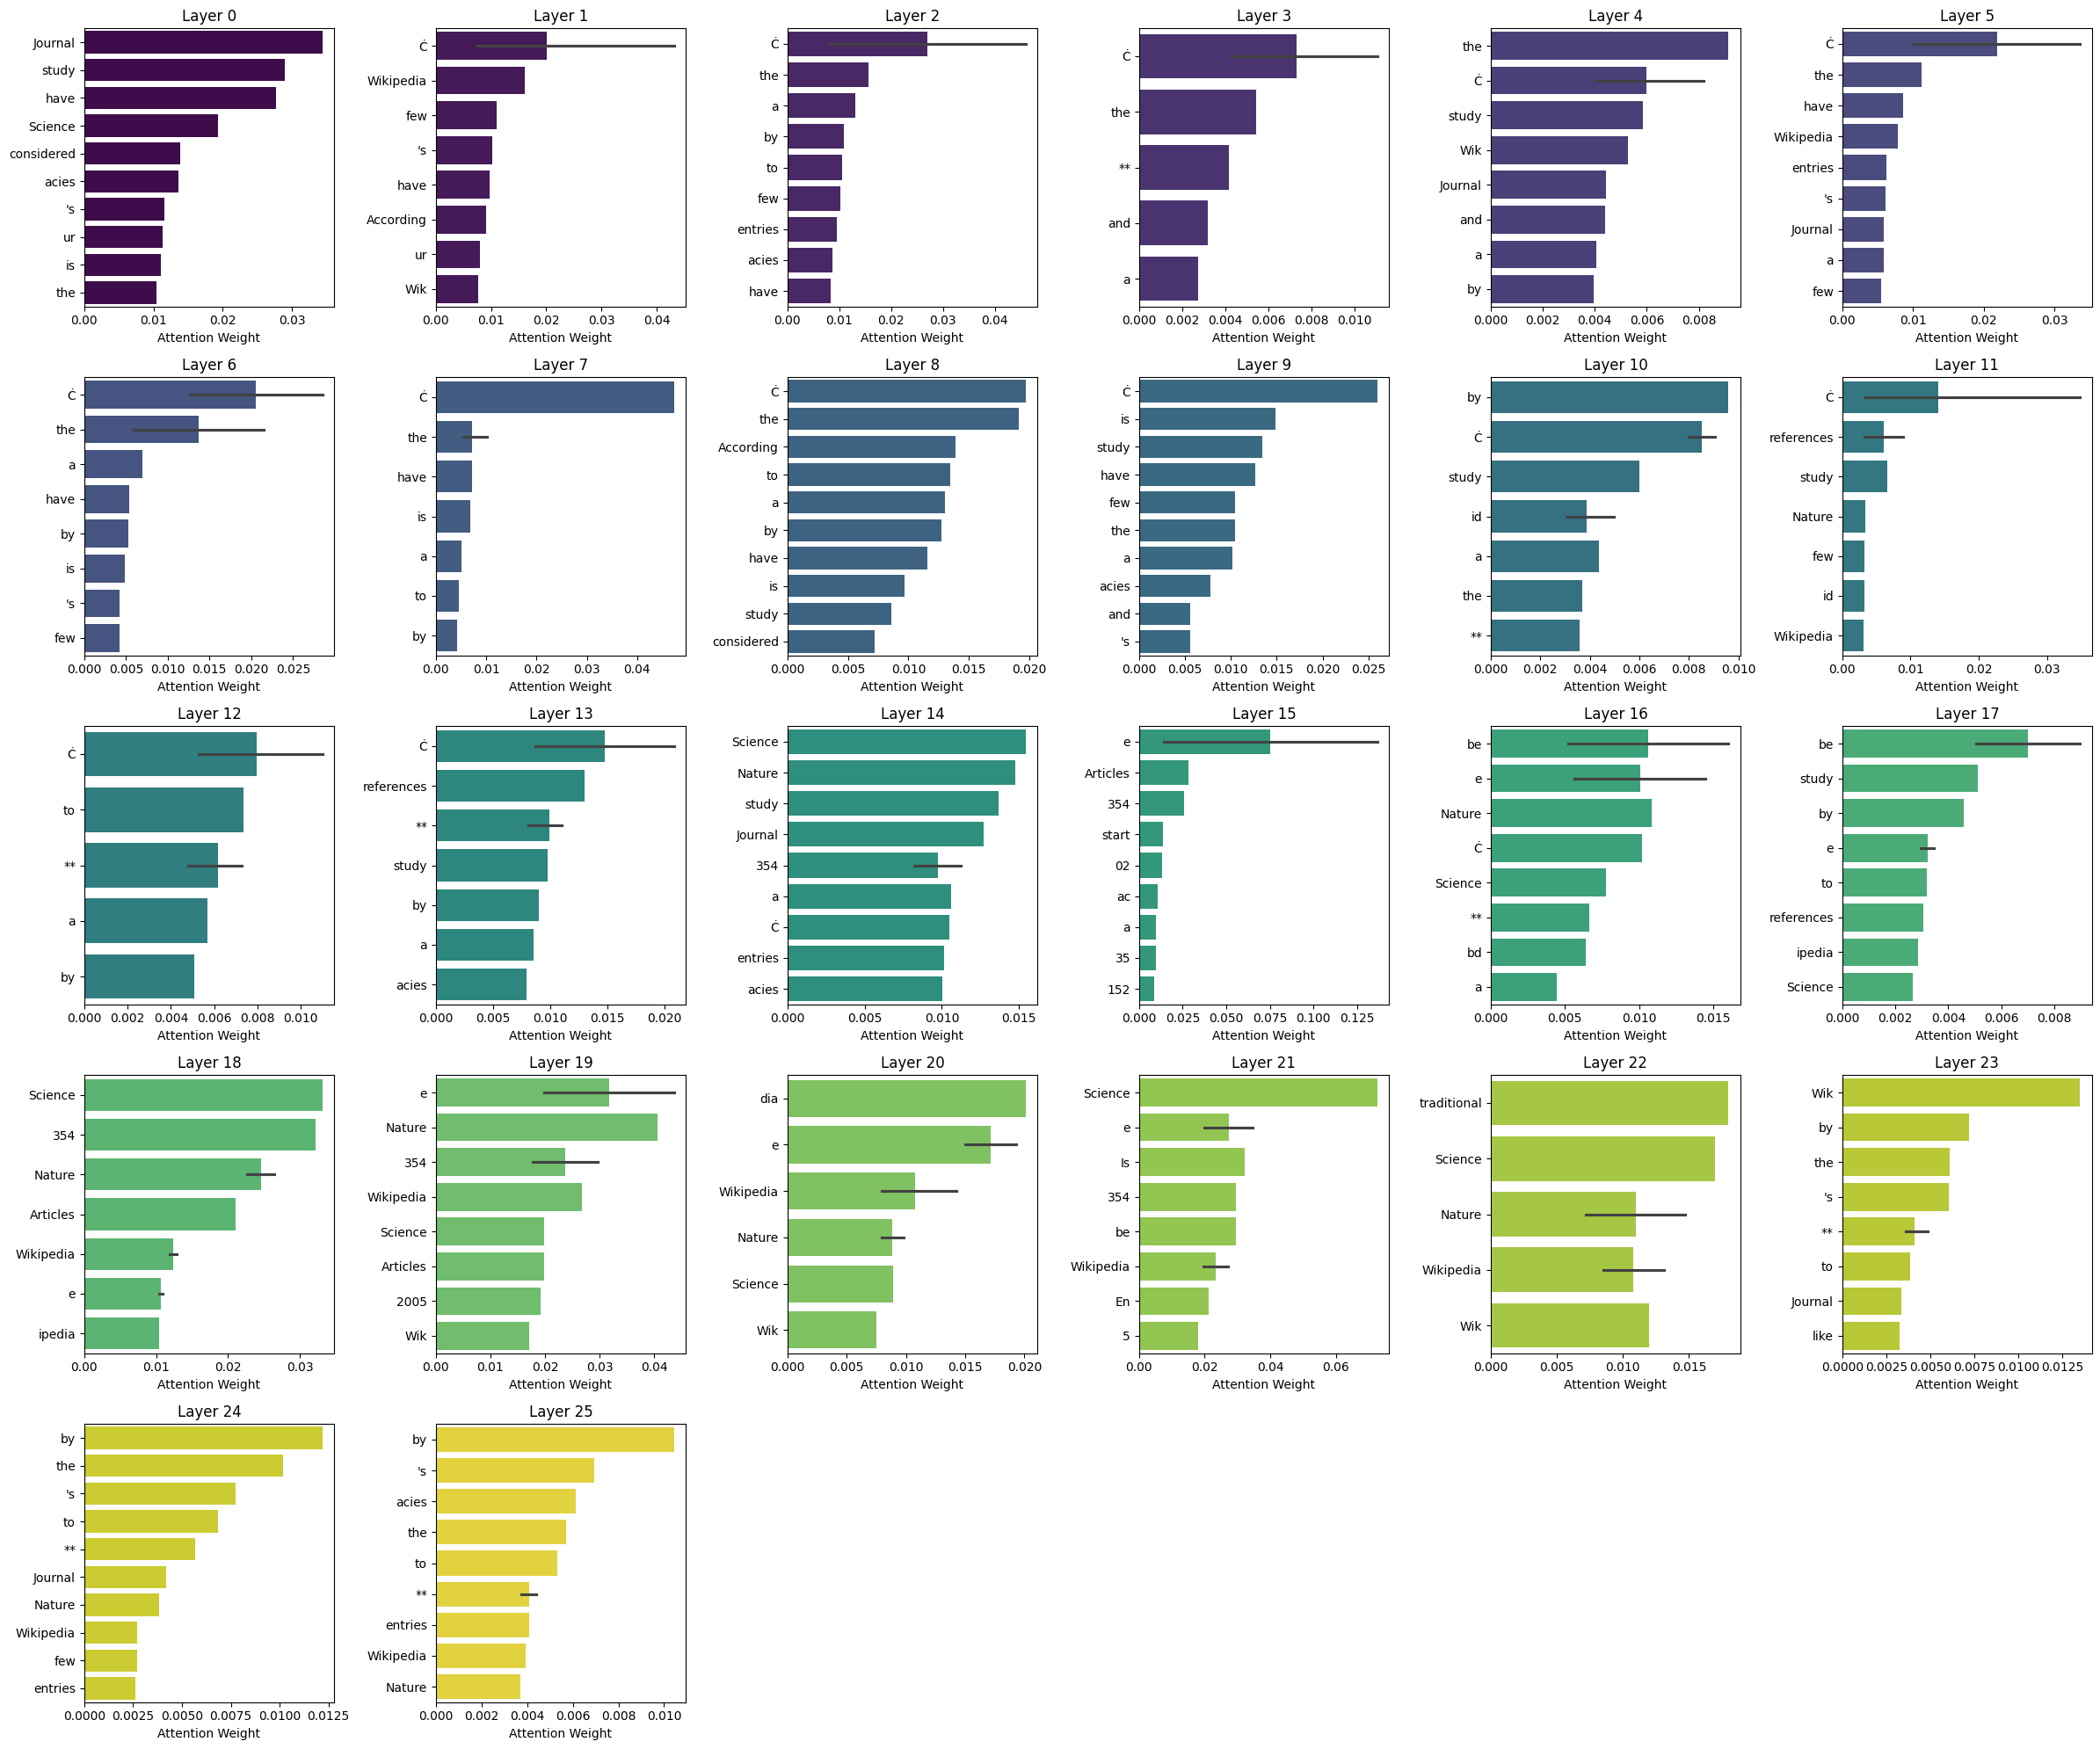

In [ ]:
import torch
import numpy as np
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import LlamaTokenizer, LlamaForCausalLM

def clean_token(token):
    """Clean special characters from tokens."""
    # Remove the Ġ character (space indicator in tokenization)
    return token.replace('Ġ', '')

def filter_tokens(tokens, attention_weights):
    """Filter out uninteresting tokens and their attention weights."""
    TOKENS_TO_FILTER = {
        '<|begin_of_text|>', '<', '>', '=', 'ref', 'Ġname', '"'
    }

    keep_indices = [
        i for i, token in enumerate(tokens)
        if token not in TOKENS_TO_FILTER
        and not any(c in '[]<>|=' for c in token)
        and not all(c in string.punctuation for c in token)  # Filter pure punctuation tokens
        and token.strip(string.punctuation)  # Filter tokens that become empty when punctuation is removed
    ]

    return (
        [clean_token(tokens[i]) for i in keep_indices],
        attention_weights[..., keep_indices] if attention_weights.ndim > 1 else attention_weights[keep_indices]
    )

def process_attention_weights(attention_weights, input_ids, tokenizer, top_k=10):
    """Process attention weights and prepare data for visualization."""
    # Convert all layers to numpy and stack
    all_layers_attention = [layer.cpu().numpy() for layer in attention_weights]
    stacked_attention = np.stack(all_layers_attention)

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    # Prepare data for plotting
    plot_data = []

    # Process each layer separately
    for layer_idx in range(stacked_attention.shape[0]):
        # Get last token attention for current layer
        layer_attention = stacked_attention[layer_idx, 0, :, -1, :]  # [heads, seq_len]
        mean_attention = layer_attention.mean(axis=0)  # Average across heads

        # Filter tokens and attention weights
        filtered_tokens, filtered_attention = filter_tokens(tokens, mean_attention)

        # Create pairs and sort
        token_attention_pairs = list(zip(filtered_tokens, filtered_attention))
        sorted_pairs = sorted(token_attention_pairs, key=lambda x: x[1], reverse=True)

        # Take top k tokens
        for token, attention in sorted_pairs[:top_k]:
            plot_data.append({
                'Layer': f'Layer {layer_idx}',
                'Token': token,
                'Attention': attention
            })

    return pd.DataFrame(plot_data)

def plot_attention_by_layer(df, num_layers, top_k=10):
    """Create faceted bar plot of attention weights with 6 subplots per row."""
    # Calculate number of rows needed with 6 plots per row
    num_rows = (num_layers + 5) // 6  # Round up division

    # Calculate figure size based on number of rows
    fig_height = 4 * num_rows  # Adjust multiplier as needed
    fig_width = 24  # Width to accommodate 6 subplots per row

    fig = plt.figure(figsize=(fig_width, fig_height))

    # Generate a color palette with different colors for each layer
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))

    # Create subplot for each layer
    for layer_idx in range(num_layers):
        layer_name = f'Layer {layer_idx}'
        layer_data = df[df['Layer'] == layer_name]

        plt.subplot(num_rows, 6, layer_idx + 1)

        # Create horizontal bar plot with reversed order (highest attention first)
        sns.barplot(
            data=layer_data,
            y='Token',
            x='Attention',
            order=layer_data.sort_values('Attention', ascending=False)['Token'],
            color=colors[layer_idx]
        )

        plt.title(f'Layer {layer_idx}')
        plt.xlabel('Attention Weight')
        plt.ylabel('')

    plt.tight_layout()
    return fig

def analyze_and_visualize_attention(model_outputs, input_ids, tokenizer, top_k=10):
    """Main function to analyze attention weights and create visualization."""
    attention_weights = model_outputs.attentions

    if attention_weights:
        # Process attention weights
        df = process_attention_weights(attention_weights, input_ids, tokenizer, top_k=top_k)

        # Create visualization
        num_layers = len(attention_weights)
        fig = plot_attention_by_layer(df, num_layers, top_k=top_k)

        # Print statistics
        print("\nAttention Statistics:")
        print(f"Number of layers: {num_layers}")
        print(f"Top {top_k} tokens shown per layer")

        return df, fig
    else:
        print("Unable to get attention weights")
        return None, None

# Example usage:
with torch.no_grad():
    outputs = model(
        input_ids,
        output_attentions=True,
        return_dict=True
    )

# Analyze and visualize
df, fig = analyze_and_visualize_attention(outputs, input_ids, tokenizer, top_k=10)
plt.show()

We do start getting some interpretive insights. Most layers still attend to the immediate token surroundings, but some do expand to long range relationship with potentially citable text. And, even more interesting and critical the source ids are heavily affecting our predictions in layer n°15, 16, 17, 18, 19, 20 and 21 (and, yeah this is heavily clustered, and no I have no real clue why it's the case).

We'll go back to it later, but for now let's coalesce all predictions by running a mean of attention weight across all layers.

This time we are also no longer just visualizing attention scores per tokens but per unique occurrences of tokens (with their associated position in the original text). Especially since our main focus is on citation, we are not interested in all occurrences of "the" but on the specific ones that may suggest the model is likely to quote this part.

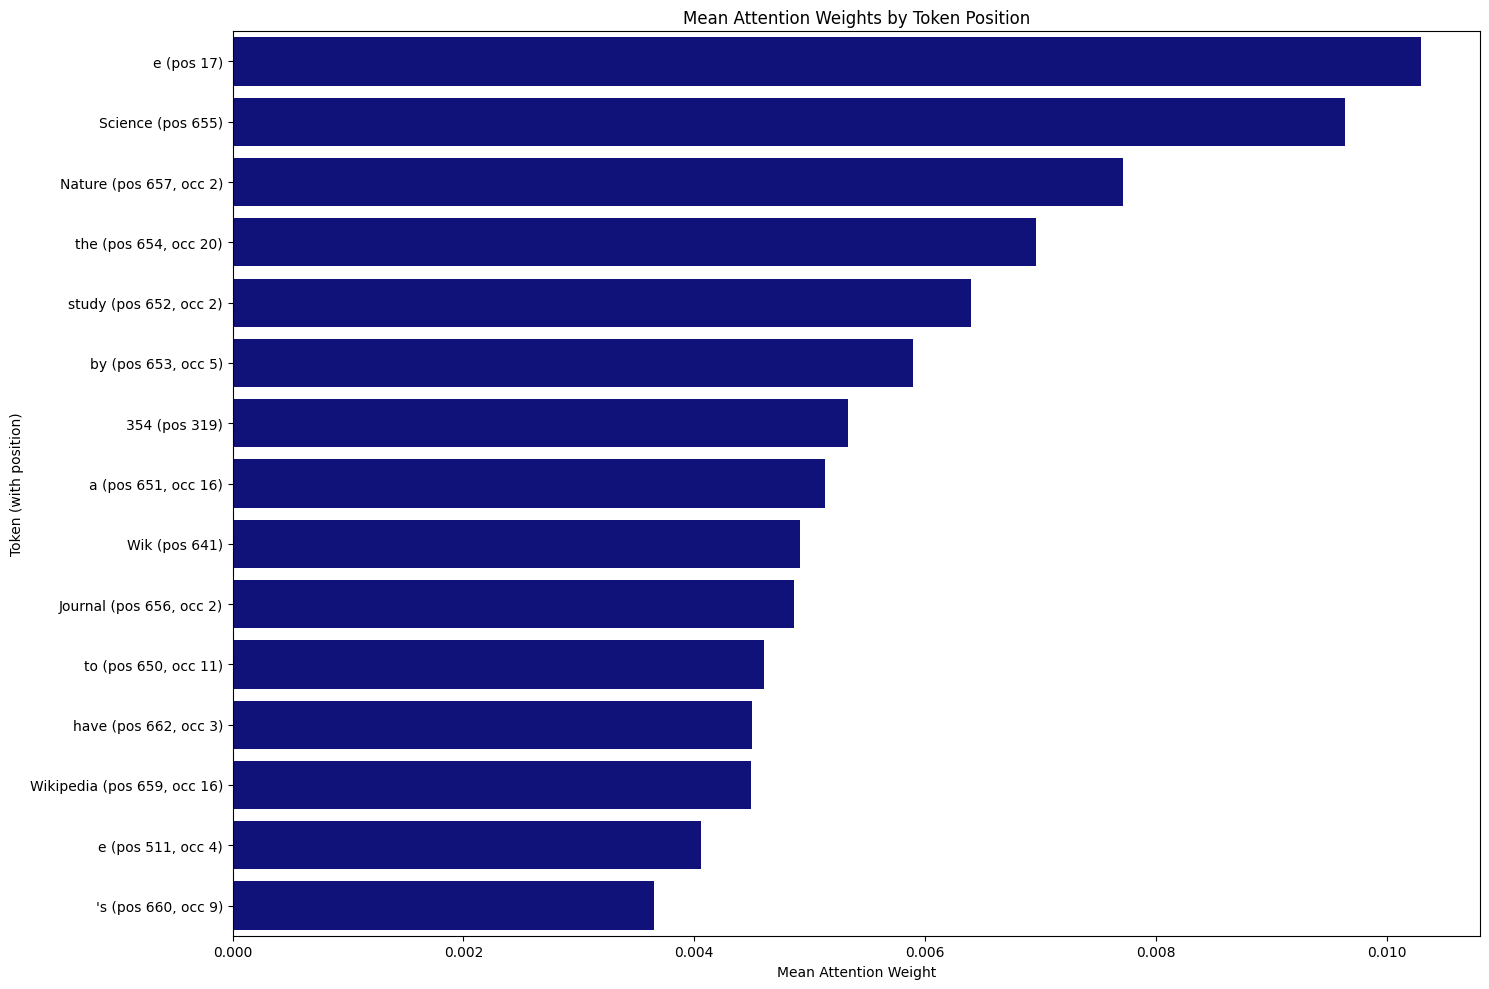

In [ ]:
def clean_token(token):
    """Clean special characters from tokens."""
    # Remove the Ġ character (space indicator) and newline characters
    cleaned = token.replace('Ġ', '')
    # Remove 'Ċ' (newline character)
    cleaned = cleaned.replace('Ċ', '')
    return cleaned

def filter_tokens(tokens, attention_weights):
    """Filter out uninteresting tokens and their attention weights."""
    TOKENS_TO_FILTER = {
        '<|begin_of_text|>', '<', '>', '=', 'ref',
        '<|source_id_start|>', '<|source_id_end|>',
        '<|source_start|>', '<|source_end|>', "Ġname"
    }

    keep_indices = [
        i for i, token in enumerate(tokens)
        if token not in TOKENS_TO_FILTER
        and not any(c in '[]<>|=' for c in token)
        and not all(c in string.punctuation for c in token)
        and token.strip(string.punctuation)
        and 'Ċ' not in token  # Filter out newline characters
    ]

    return (
        [clean_token(tokens[i]) for i in keep_indices],
        attention_weights[..., keep_indices] if attention_weights.ndim > 1 else attention_weights[keep_indices],
        keep_indices
    )

def process_unique_tokens(filtered_tokens, filtered_attention, keep_indices):
    """Process tokens to create unique token-position pairs with their attention weights."""
    token_info = []
    token_counts = {}

    for idx, (token, attention) in enumerate(zip(filtered_tokens, filtered_attention)):
        original_pos = keep_indices[idx]
        if token in token_counts:
            token_counts[token] += 1
            display_token = f"{token} (pos {original_pos}, occ {token_counts[token]})"
        else:
            token_counts[token] = 1
            display_token = f"{token} (pos {original_pos})"

        token_info.append((display_token, attention, original_pos))

    return token_info

def plot_mean_attention(token_info, top_k=30):
    """Create a horizontal bar plot of mean attention weights for unique token-position pairs."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Token': [t[0] for t in token_info],
        'Attention': [t[1] for t in token_info]
    })

    # Sort by attention weight and get top k
    df_sorted = df.nlargest(top_k, 'Attention')

    # Create figure
    plt.figure(figsize=(15, 10))

    # Create horizontal bar plot
    sns.barplot(
        data=df_sorted,
        y='Token',
        x='Attention',
        order=df_sorted['Token'],
        color='darkblue'
    )

    plt.title('Mean Attention Weights by Token Position')
    plt.xlabel('Mean Attention Weight')
    plt.ylabel('Token (with position)')

    plt.tight_layout()
    return plt.gcf()

def analyze_mean_attention(model_outputs, input_ids, tokenizer, top_k=30):
    """Process and visualize mean attention weights across all layers."""
    attention_weights = model_outputs.attentions

    if attention_weights:
        # Process attention weights
        all_layers_attention = [layer.cpu().numpy() for layer in attention_weights]
        stacked_attention = np.stack(all_layers_attention)
        last_token_attention = stacked_attention[:, 0, :, -1, :]
        mean_attention = last_token_attention.mean(axis=(0, 1))

        # Get and filter tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
        filtered_tokens, filtered_attention, keep_indices = filter_tokens(tokens, mean_attention)

        # Process unique token-position pairs
        token_info = process_unique_tokens(filtered_tokens, filtered_attention, keep_indices)

        # Sort by attention weight
        sorted_info = sorted(token_info, key=lambda x: x[1], reverse=True)

        # Create visualization
        fig = plot_mean_attention(sorted_info, top_k=top_k)

        # Calculate statistics
        unique_tokens = len(set(t.split(' (')[0] for t, _, _ in token_info))
        stats = {
            "num_tokens": len(filtered_tokens),
            "num_unique_tokens": unique_tokens,
            "max_attention": filtered_attention.max(),
            "min_attention": filtered_attention.min(),
            "mean_attention": filtered_attention.mean()
        }

        return sorted_info, fig, stats
    else:
        print("Unable to get attention weights")
        return None, None, None

# Example usage:
with torch.no_grad():
    outputs = model(
        input_ids,
        output_attentions=True,
        return_dict=True
    )

token_info, fig, stats = analyze_mean_attention(outputs, input_ids, tokenizer, top_k=15)
plt.show()

Graph clearly shows that the most attended token is the one are likely to quote. And beyond that it's not just the generic placeholder for our reference id, but the actual **opening** or our reference text. Moreover the other words are either coming from the immediate previous sentence or from the source excerpt its liable to quote.

We can check in more detail using an alternative visualization: highlighting the original text and checking whether each word has a high enough attention score.

In [ ]:
from IPython.display import display as ipython_display
from IPython.display import HTML
import numpy as np
import string

def clean_bpe_token(token):
    """Clean BPE token by handling special characters"""
    if 'Ċ' in token or 'ĉ' in token:
        return '\n'
    token = token.replace('Ġ', ' ')
    token = token.replace('Ł', ' ')
    return token

def filter_tokens(tokens, attention_weights):
    """Filter out first two tokens and their attention weights."""
    # Keep all indices except first two
    keep_indices = list(range(2, len(tokens)))

    filtered_tokens = [tokens[i] for i in keep_indices]
    filtered_weights = attention_weights[keep_indices]

    return filtered_tokens, filtered_weights, keep_indices

def flatten_weights(weights, power=0.5):
    normalized = (weights - weights.min()) / (weights.max() - weights.min())
    flattened = np.power(normalized, power)
    return flattened

def merge_tokens(tokens, weights):
    """Merge tokens and their weights when there's no space"""
    merged_tokens = []
    merged_weights = []
    current_token = ""
    current_weight = 0
    weight_count = 0

    for token, weight in zip(tokens, weights):
        cleaned = clean_bpe_token(token)

        if cleaned == '\n':
            if current_token:
                merged_tokens.append(current_token)
                merged_weights.append(current_weight / weight_count)
            merged_tokens.append(cleaned)
            merged_weights.append(weight)
            current_token = ""
            current_weight = 0
            weight_count = 0
            continue

        # Keep punctuation separate
        if cleaned and all(c in string.punctuation for c in cleaned.strip()):
            if current_token:
                merged_tokens.append(current_token)
                merged_weights.append(current_weight / weight_count)
            merged_tokens.append(cleaned)
            merged_weights.append(weight)
            current_token = ""
            current_weight = 0
            weight_count = 0
        elif cleaned.startswith(' '):
            if current_token:
                merged_tokens.append(current_token)
                merged_weights.append(current_weight / weight_count)
            current_token = cleaned
            current_weight = weight
            weight_count = 1
        else:
            current_token += cleaned
            current_weight += weight
            weight_count += 1

    if current_token:
        merged_tokens.append(current_token)
        merged_weights.append(current_weight / weight_count)

    return merged_tokens, np.array(merged_weights)

def create_attention_vis(tokens, attention_weights, max_tokens=100, power=0.5):
    merged_tokens, merged_weights = merge_tokens(tokens, attention_weights)
    normalized_weights = flatten_weights(merged_weights, power=power)

    sorted_indices = np.argsort(merged_weights)[::-1]
    top_indices = set(sorted_indices[:max_tokens])

    html = """
    <div style="font-family: Arial, sans-serif; line-height: 2; padding: 5px; background: #f8f9fa; border-radius: 5px; white-space: pre-wrap;">
    <div style="margin-bottom: 5px;"><h2 style="margin: 0;">Most attention given to cited text</h2></div>
    """.format(max_tokens)

    for i, (token, weight, orig_weight) in enumerate(zip(merged_tokens, normalized_weights, merged_weights)):
        if token == '\n':
            html += '<br/>'
            continue

        if i in top_indices:
            html += f'<span style="background-color: rgba(0,0,255,{weight:.3f}); padding: 0.2em 0.1em; border-radius: 3px;" title="Attention: {orig_weight:.4f}">{token}</span>'
        else:
            # Minimal padding for better readability
            html += f'<span style="padding: 0.1em 0;" title="Attention: {orig_weight:.4f}">{token}</span>'

    html += """
    <div style="margin-top: 8px; font-size: 0.9em; display: flex; gap: 10px; align-items: center;">
        <span style="background-color: rgba(0,0,255,1.0); padding: 0.2em 0.5em; border-radius: 3px;">High attention</span>
        <span style="background-color: rgba(0,0,255,0.5); padding: 0.2em 0.5em; border-radius: 3px;">Medium attention</span>
        <span style="background-color: rgba(0,0,255,0.1); padding: 0.2em 0.5em; border-radius: 3px;">Low attention</span>
    </div>
    </div>
    """

    return HTML(html)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    # Filter tokens and attention weights after model execution
    filtered_tokens, filtered_attention, _ = filter_tokens(tokens, mean_attention)

    ipython_display(create_attention_vis(filtered_tokens, filtered_attention, max_tokens=150, power=0.5))

What we can clearly see: attention is working like an hermeneutics process. The model is actively reading different parts of the text, drawing obviously from the preceding sentence in a typical predict the next tokens way but also:
* Reading closely the source analysis parts and comparing the general summary of each source to draw information from it.
* Attending to the each source using the built-in structure.
* Focusing more specifically on source 1 and source 3 and already identifying candidates for citation.

Let's move up to another step, once the model has settled on a source to quote.

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\""""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    # Filter tokens and attention weights after model execution
    filtered_tokens, filtered_attention, _ = filter_tokens(tokens, mean_attention)

    ipython_display(create_attention_vis(filtered_tokens, filtered_attention, max_tokens=150, power=0.5))

The attention distribution is now very different:
* the model mostly focuses on the source 1 now.
* it draws again both from the source analysis and the original text, even though the latter is more attended to as the model is switching into citation mode.
* the model is now deepening its reading of the original excerpts, drawing not just from anchor words but continuous sequence of texts.

Finally we can check the attention scores once the model has started citing:

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\"a peer review"""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    # Filter tokens and attention weights after model execution
    filtered_tokens, filtered_attention, _ = filter_tokens(tokens, mean_attention)

    ipython_display(create_attention_vis(filtered_tokens, filtered_attention, max_tokens=150, power=0.5))

Long range attention signals are very strong now and rivaling with the short range one, as the model is equally focusing on the current sentence and the one it's reproducing.

## Dynamics of attention

Until now we have worked one token at a time. Yet LLM generation is dynamic and the comparison of our last visualization is clearly showing how attention is shifting all the time. Similarly to adaptive temperature or logits entropy, can we model the dynamics of attention at inference time?

For now, we'll not attempt to create an actual sampler, just keep the text as is but leverage differential attention scores per text part as an interpretive tool.

Our next visualization will proceed in this way:
* Loop back to the tokens generated since <|answer_start|> (all the sentence "Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name="ebea70a3502acfbd">"a peer review"
* For each token, compute the total attention score of each past token.
* Aggregate thoses score per text part.
* Compare the evolution of attention focus in the different component of our RAG system: the query, each individual source, the analysis and the answer itself.

First we create a visualization script in plotly, assigning each past token to its text part:

In [ ]:
import numpy as np
import plotly.graph_objects as go

def analyze_attention_distribution(tokens, mean_attention):
    """
    Analyze total attention distribution with individual source breakdown.

    Args:
        tokens: List of tokens from the tokenizer
        mean_attention: numpy array of mean attention scores per token

    Returns:
        dict: Dictionary containing total attention for each section
    """
    # Initialize segment indices
    segments = {
        'query': {'start': -1, 'end': -1},
        'sources': [],
        'source_analysis': {'start': -1, 'end': -1},
        'answer': {'start': -1, 'end': -1}
    }

    # Find segment boundaries
    for i, token in enumerate(tokens):
        if token == '<|query_start|>':
            segments['query']['start'] = i
        elif token == '<|query_end|>':
            segments['query']['end'] = i
        elif token == '<|source_start|>':
            segments['sources'].append({'start': i})
        elif token == '<|source_end|>':
            segments['sources'][-1]['end'] = i
        elif token == '<|source_analysis_start|>':
            segments['source_analysis']['start'] = i
        elif token == '<|source_analysis_end|>':
            segments['source_analysis']['end'] = i
        elif token == '<|answer_start|>':
            segments['answer']['start'] = i
            segments['answer']['end'] = len(tokens)

    # Calculate metrics
    metrics = {
        'query': np.sum(mean_attention[segments['query']['start']:segments['query']['end']]),
        'sources': [np.sum(mean_attention[source['start']:source['end']])
                   for source in segments['sources']],
        'analysis': np.sum(mean_attention[segments['source_analysis']['start']:
                                        segments['source_analysis']['end']]),
        'answer': np.sum(mean_attention[segments['answer']['start']:segments['answer']['end']])
    }

    return metrics

def visualize_attention_distribution(metrics, title='Attention Distribution Across Text Sections'):
    """
    Create a horizontal bar chart of attention distribution with individual sources.

    Args:
        metrics: Dictionary containing total attention for each section
    """
    # Prepare data
    sections = ['Query'] + [f'Source {i+1}' for i in range(len(metrics['sources']))] + ['Analysis', 'Answer']
    values = [metrics['query']] + metrics['sources'] + [metrics['analysis'], metrics['answer']]

    # Create color scale for sources
    n_sources = len(metrics['sources'])
    source_colors = [f'rgb(255, {int(200 - i * (200/n_sources))}, 0)' for i in range(n_sources)]
    colors = ['#1f77b4'] + source_colors + ['#2ca02c', '#d62728']

    # Create horizontal bar chart
    fig = go.Figure(go.Bar(
        x=values,
        y=sections,
        orientation='h',
        marker_color=colors
    ))

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title='Total Attention',
        yaxis_title='Text Sections',
        height=500,  # Increased height to accommodate more bars
        width=800,
        showlegend=False,
        yaxis={'categoryorder': 'array',
               'categoryarray': sections[::-1]}  # reverse order
    )

    return fig

Now we can run our script first on the sentence while the source is not yet selected:

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\""""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    metrics = analyze_attention_distribution(tokens, mean_attention)

    fig = visualize_attention_distribution(metrics, title='Attention distribution before source selection')
    fig.show()

The attention score distribution is basically confirming what was already visible in the previous highlighting visualization:
* The model is heavily attending to the pre-analysis step, taking advantage of the summary to navigate more easily across the sources.
* Source 1 and Source 3 are the main candidate to answer the question, with a short advantage for source 1 (actually more intense if we take into account the fact that source id 1 has a much higher attention score).
* Answer text concentrates all the attention which is very predictably due to the premium given to short range attention.

Now let's rerun the graph later in the generation, as the quote is already settled:

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\""""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    metrics = analyze_attention_distribution(tokens, mean_attention)

    fig = visualize_attention_distribution(metrics, title='Attention distribution after source selection')
    fig.show()

This is a noticeably different landscape: attention remains focused on analysis but is other wise but much concentrated on source 1, as the model is actively citing it.

Let's generalize now this approach for the entire text. Instead of outputting one graph per token, we'll switch to a continuous representation across the time axis:

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_per_token_attention(tokens, all_layers_attention):
    """
    Analyze attention patterns for each generated token after answer_start.

    Args:
        tokens: List of tokens from the tokenizer
        all_layers_attention: numpy array of shape [n_layers, batch_size, n_heads, seq_len, seq_len]
    """
    # Find segment boundaries
    segments = {
        'query': {'start': -1, 'end': -1},
        'sources': [],
        'source_analysis': {'start': -1, 'end': -1},
        'answer_start': -1
    }

    for i, token in enumerate(tokens):
        if token == '<|query_start|>':
            segments['query']['start'] = i
        elif token == '<|query_end|>':
            segments['query']['end'] = i
        elif token == '<|source_start|>':
            segments['sources'].append({'start': i})
        elif token == '<|source_end|>':
            segments['sources'][-1]['end'] = i
        elif token == '<|source_analysis_start|>':
            segments['source_analysis']['start'] = i
        elif token == '<|source_analysis_end|>':
            segments['source_analysis']['end'] = i
        elif token == '<|answer_start|>':
            segments['answer_start'] = i

    # Get number of generated tokens
    n_generated = len(tokens) - segments['answer_start'] - 1

    # For each generated token, get its attention pattern
    attention_patterns = []

    # For each generated token position
    for pos in range(segments['answer_start'] + 1, len(tokens)):
        # Get attention pattern for this position across all layers and heads
        token_attention = all_layers_attention[:, 0, :, pos, :]

        # Average across layers and heads
        mean_attention = token_attention.mean(axis=(0, 1))

        # Normalize attention scores
        mean_attention = mean_attention / mean_attention.sum()

        attention_patterns.append(mean_attention)

    attention_patterns = np.stack(attention_patterns)

    # Calculate section-wise attention
    metrics = {
        'generated_tokens': tokens[segments['answer_start']+1:],
        'query_attention': np.array([
            pattern[segments['query']['start']:segments['query']['end']].sum()
            for pattern in attention_patterns
        ]),
        'source_attention': [
            np.array([
                pattern[source['start']:source['end']].sum()
                for pattern in attention_patterns
            ])
            for source in segments['sources']
        ],
        'analysis_attention': np.array([
            pattern[segments['source_analysis']['start']:segments['source_analysis']['end']].sum()
            for pattern in attention_patterns
        ])
    }

    return metrics

def visualize_token_attention(metrics, viz_title = 'Attention Patterns During Token Generation'):
    """
    Create line plots showing attention patterns with token tooltips.
    """
    # Create figure with 3 subplots
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=('Query Attention', 'Source Attention', 'Analysis Attention'),
        vertical_spacing=0.15,
        row_heights=[0.33, 0.33, 0.33]
    )

    # Create hover text with generated tokens
    hover_template = "Token: %{text}<br>Attention: %{y:.4f}<br>Step: %{x}"

    # Add query attention trace
    fig.add_trace(
        go.Scatter(
            y=metrics['query_attention'],
            mode='lines+markers',
            name='Query',
            line=dict(color='#1f77b4'),
            text=metrics['generated_tokens'],
            hovertemplate=hover_template
        ),
        row=1, col=1
    )

    # Add source attention traces
    colors = ['#ff7f0e', '#2ca02c', '#d62728']  # Different colors for each source
    for i, source_attn in enumerate(metrics['source_attention']):
        fig.add_trace(
            go.Scatter(
                y=source_attn,
                mode='lines+markers',
                name=f'Source {i+1}',
                line=dict(color=colors[i % len(colors)]),
                text=metrics['generated_tokens'],
                hovertemplate=hover_template
            ),
            row=2, col=1
        )

    # Add analysis attention trace
    fig.add_trace(
        go.Scatter(
            y=metrics['analysis_attention'],
            mode='lines+markers',
            name='Analysis',
            line=dict(color='#9467bd'),
            text=metrics['generated_tokens'],
            hovertemplate=hover_template
        ),
        row=3, col=1
    )

    # Update layout
    fig.update_layout(
        height=600,  # Reduced height since we removed one panel
        width=1200,
        showlegend=True,
        title=viz_title,
        hovermode='x unified'  # Show tooltips for all traces at the same x-coordinate
    )

    # Update axes
    for i in range(1, 4):
        fig.update_xaxes(title_text="Generation Step", row=i, col=1)
        fig.update_yaxes(title_text="Attention Score", row=i, col=1)

    return fig

We run this new approach on the same prompt:

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia 'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name=\"ebea70a3502acfbd\">\"a peer review"""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    metrics = analyze_per_token_attention(tokens, stacked_attention)
    fig = visualize_token_attention(metrics)
    fig.show()

What we have now is a generation step since the beginning of the answer (*not* the entire text). Each dot is a token that be seen in the tooltip. The graphs are showing the differential attention score as the answer text is progressing:
* Preditibly, the model gets futher from the source summary (the part immediately before the answer), even though it remains a constant after a while.
* The query is heavily recalled at first, as the model try to answer/reformulate the question directly before elaborating on.
* Each source gets varying amount of attention as the text is threading on different topic, until the moment where it settles on using source 1 for a citation.

We can generalize this approach to an entire text. As token per token generation is very ineffective, we'll use model generate instead to output what comes next.

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt", padding=False).to(device)

outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=1000,
            repetition_penalty=1,
            do_sample=False,
            early_stopping=True,
            use_cache=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=2
        )

result = tokenizer.decode(outputs[0], skip_special_tokens=False)

print(result)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning:

`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC Wo

Then we put it back in the prompt:

In [ ]:
prompt = """<|query_start|>Is Wikipedia considered reliable?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|> Articles for traditional encyclopedias such as Encyclopædia Britannica are written by experts, lending such encyclopedias a reputation for accuracy. However, a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy, and concluded that 'the average science entry in Wikipedia contained around four inaccuracies; Britannica, about three.' Joseph Reagle suggested that while the study reflects 'a topical strength of Wikipedia contributors' in science articles.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|> As a consequence of the open structure, Wikipedia'makes no guarantee of validity' of its content, since no one is ultimately responsible for any claims appearing in it. Concerns have been raised by PC World in 2009 regarding the lack of accountability that results from users' anonymity, the insertion of false information, vandalism, and similar problems. Legal Research in a Nutshell (2011), cites Wikipedia as a 'general source' that 'can be a realboon' in 'coming up to speed in the law governing a situation' and, 'while not authoritative, can provide basic facts as well as leads to more in-depth resources'.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|> Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia. In response to paid advocacy editing and undisclosed editing issues, Wikipedia was reported in an article in The Wall Street Journal to have strengthened its rules and laws against undisclosed editing. The article stated that: 'Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement.<|source_end|>
<|source_analysis_start|>The user is asking about the reliability of Wikipedia's content compared to other encyclopedias. The references provided include a variety of sources that discuss Wikipedia's reliability, the impact of its open structure, and the challenges faced by Wikipedia in maintaining its content.

1. **ebea70a3502acfbd** discusses the accuracy of Wikipedia's entries compared to other encyclopedias like Encyclopædia Britannica, noting that while some entries are accurate, others are not.
2. **5f862e733d38288e** highlights the lack of accountability and the potential for legal issues related to Wikipedia's content.
3. **354fa4908152b336** addresses the issue of paid advocacy editing and the need for stricter rules against undisclosed editing.

These references provide a comprehensive view of the reliability and challenges of Wikipedia's content.<|source_analysis_end|>
<|answer_start|>Wikipedia's content is considered reliable. According to a study by the Science Journal Nature, Wikipedia's entries have few inaccuracies<ref name="ebea70a3502acfbd">"a peer review in 2005 of forty-two scientific entries on both Wikipedia and Encyclopædia Britannica by the science journal Nature found few differences in accuracy"</ref>. This indicates that while Wikipedia's content is generally accurate, it may not always be as reliable as other encyclopedias.

However, the open structure of Wikipedia itself makes it an attractive target for Internet trolls and spammers. Wikipedia's structure allows for transparency and verification, which can be beneficial for those seeking to engage with the internet<ref name="5f862e733d38288e">"Wikipedia's open structure inherently makes it an easy target for Internet trolls, spammers, and various forms of paid advocacy seen as counterproductive to the maintenance of a neutral and verifiable online encyclopedia"</ref>.

Despite these benefits, there are also challenges. One significant issue is the lack of accountability and the potential for legal disputes. The study by the Science Journal Nature found that while Wikipedia's content is generally accurate, there are instances where it may not be as reliable as other encyclopedias<ref name="ebea70a3502acfbd">"no one is ultimately responsible for any claims appearing in it"</ref>.

Additionally, the presence of paid advocacy editing and the need for stricter rules against undisclosed editing further complicate the situation. Wikipedia has been criticized for its handling of such issues, which can lead to conflicts and legal battles<ref name="354fa4908152b336">"Beginning Monday [from the date of the article, June 16, 2014], changes in Wikipedia's terms of use will require anyone paid to edit articles to disclose that arrangement"</ref>.

In summary, while Wikipedia's content is generally reliable, it may not always be as reliable as other encyclopedias. However, the open structure of Wikipedia allows for transparency and verification, and there are challenges related to accountability and legal issues.<|answer_end|><|end_of_text|>"""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    metrics = analyze_per_token_attention(tokens, stacked_attention)
    fig = visualize_token_attention(metrics)
    fig.show()

What we can now clearly see: different phases of source attention/focus, as model is successively citing the various references. More interestingly we also notice some attention patterns *prior* to citation which is something we definitely intend to leverage to enhance sampling methods. It should be possible to:
* Correct mis-attributed citations. Typically the sentence "no one is ultimately responsible for any claims appearing in it" is ultimately coming from source 2 not source 1 and the attention scores do adequately track that.
* Enfore citations where needed. Some of the spikes, especially for reference 3, are not associated with references and citations, even though the attention scores clearly show the model is drawing from it.
* Varying generation strategies depending on the different text modes. While citations should always be generated without any temperature, this is not necessarily the best approach for the reste of the text. We may need some adaptive attention here.

## A final bonus: in Latin!

For now we have run all our tests in English, but Pico is able to perform RAG in a variety of European languages: French, Italian, German, Spanish and even… Latin.

In [ ]:
 prompt = """<|query_start|>Quod est Vicipaedia?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|>Vicipaedia Latina, vel Vicipaedia tantum, est editio Vicipaediae Latine scripta, et quidem pars societatis Vicimediae. Anno 2013 mense Decembri numerum 100 000 paginarum superavit. Hodie 139 665 commentationes et fere 144 utentes strenuos habet.[1] "Vicipaedia Latina scribi coepta est anno 2002.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|>Vicipaedia est opus commune, quo encyclopaedia libera interretialis creetur. Non solum neque imprimis de rebus antiquis agit, verum de cunctis rebus encyclopaedicis. A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|>Multi sunt qui, cum primum Vicipaediae limina intrant, magnopere mirentur tantas commentationes nostris diebus esse factas lingua, qua nemo iam (aut nondum) utitur patrio sermone, qua perpauci scientiae disciplinas doctrinamque suam exponere solent, qua ne Romana quidem Ecclesia in Dei operibus pronuntiandis satis strenue utitur<|source_end|>
<|source_analysis_start|>"""

inputs = tokenizer(prompt, return_tensors="pt", padding=False).to(device)

outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=1000,
            repetition_penalty=1,
            do_sample=False,
            early_stopping=True,
            use_cache=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=2
        )

result = tokenizer.decode(outputs[0], skip_special_tokens=False)

print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|query_start|>Quod est Vicipaedia?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|>Vicipaedia Latina, vel Vicipaedia tantum, est editio Vicipaediae Latine scripta, et quidem pars societatis Vicimediae. Anno 2013 mense Decembri numerum 100 000 paginarum superavit. Hodie 139 665 commentationes et fere 144 utentes strenuos habet.[1] "Vicipaedia Latina scribi coepta est anno 2002.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|>Vicipaedia est opus commune, quo encyclopaedia libera interretialis creetur. Non solum neque imprimis de rebus antiquis agit, verum de cunctis rebus encyclopaedicis. A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|>Multi sunt qui, cum primum Vicipaediae limina intrant, magnopere mirentur tantas commentationes nostris diebus esse factas ling

In [ ]:
prompt = """<|query_start|>Quod est Vicipaedia?<|query_end|>
<|source_start|><|source_id_start|>ebea70a3502acfbd<|source_id_end|>Vicipaedia Latina, vel Vicipaedia tantum, est editio Vicipaediae Latine scripta, et quidem pars societatis Vicimediae. Anno 2013 mense Decembri numerum 100 000 paginarum superavit. Hodie 139 665 commentationes et fere 144 utentes strenuos habet.[1] "Vicipaedia Latina scribi coepta est anno 2002.<|source_end|>
<|source_start|><|source_id_start|>5f862e733d38288e<|source_id_end|>Vicipaedia est opus commune, quo encyclopaedia libera interretialis creetur. Non solum neque imprimis de rebus antiquis agit, verum de cunctis rebus encyclopaedicis. A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis.<|source_end|>
<|source_start|><|source_id_start|>354fa4908152b336<|source_id_end|>Multi sunt qui, cum primum Vicipaediae limina intrant, magnopere mirentur tantas commentationes nostris diebus esse factas lingua, qua nemo iam (aut nondum) utitur patrio sermone, qua perpauci scientiae disciplinas doctrinamque suam exponere solent, qua ne Romana quidem Ecclesia in Dei operibus pronuntiandis satis strenue utitur<|source_end|>
<|source_analysis_start|>Quaestio a usore posita est de "Vicipaedia Latina" et quomodo haec editio ad studia encyclopaedica et commentationes in lingua Latina pertinet. Textus praebiti varias informationes de Vicipaedia Latina et eius evolutione, usu in studiis encyclopaedicis, et commentationibus in lingua Latina praebent.

Textus **ebea70a3502acfbd** describit Vicipaediam Latinam, quae est editio Vicipaediae Latine scripta, et eius evolutionem. **5f862e733d38288e** mentionem facit de Vicipaedia Latina et commentationibus in lingua Latina. **354fa4908152b336** refert de commentationibus in lingua Latina et de studiis encyclopaedicis.<|source_analysis_end|>
<|answer_start|>Vicipaedia Latina est editio Vicipaediae Latine scripta, quae anno 2013 mense Decembri numerum 100 000 paginarum superavit<ref name="ebea70a3502acfbd">"Vicipaedia Latina scribi coepta est anno 2002."</ref>. Haec editio non solum de rebus antiquis agit, sed etiam de cunctis rebus encyclopaedicis<ref name="5f862e733d38288e">"A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis."</ref>.

In studiis encyclopaedicis, Vicipaedia Latina saepe adhibetur ad commentationes in lingua Latina, quae non solum de rebus antiquis sed etiam de cunctis rebus encyclopaedicis sunt<ref name="ebea70a3502acfbd">"Non solum neque imprimis de rebus antiquis agit, verum de cunctis rebus encyclopaedicis."</ref>. Haec commentationes non solum ad linguam Latinam sed etiam ad studia encyclopaedica pertinent, quae saepe in academiis et bibliothecis studiorum publicorum sunt<ref name="5f862e733d38288e">"A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis."</ref>.

Praeterea, Vicipaedia Latina non solum de rebus antiquis sed etiam de cunctis rebus encyclopaedicis agit, quod indicat quod haec editio non solum ad studia encyclopaedica sed etiam ad studia encyclopaedica pertinet<ref name="ebea70a3502acfbd">"Non solum neque imprimis de rebus antiquis agit, verum de cunctis rebus encyclopaedicis."</ref>.

In summa, Vicipaedia Latina est editio Vicipaedia Latine scripta, quae anno 2013 mense Decembri numerum 100 000 paginarum superavit et ad studia encyclopaedica pertinet, quae non solum de rebus antiquis sed etiam de cunctis rebus encyclopaedicis sunt<ref name="ebea70a3502acfbd">"A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis."</ref><ref name="5f862e733d38288e">"A ceteris generis vici operibus eo tantum differt, quod lingua Latina utitur in commentationibus conscribendis."</ref>.<|answer_end|><|end_of_text|>"""

input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)

with torch.no_grad():
    outputs = model(
        input_ids,  # Use full input_ids
        output_attentions=True,
        return_dict=True
    )

if outputs.attentions:
    all_layers_attention = [layer.cpu().numpy() for layer in outputs.attentions]
    stacked_attention = np.stack(all_layers_attention)
    last_token_attention = stacked_attention[:, 0, :, -1, :]
    mean_attention = last_token_attention.mean(axis=(0, 1))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

    metrics = analyze_per_token_attention(tokens, stacked_attention)
    fig = visualize_token_attention(metrics, viz_title='Exempla Attentionis Durante Tokenorum Generationen')
    fig.show()

You're welcome to try it in different languages.